In [1]:
import cv2, numpy as np, matplotlib.pyplot as plt, seaborn as sns, keras, os
from sklearn.model_selection import train_test_split as tts
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle

In [2]:
path = "myData/"
myList = os.listdir(path)
myList

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [3]:
ImgList = []
classList = []
for x in myList:
    myImgList = os.listdir(path + x)
    for y in myImgList:
        currImg = cv2.imread(path + x + "/" + y)
        currImg = cv2.resize(currImg, (32, 32))
        ImgList.append(currImg)
        classList.append(int(x))

ImgList = np.array(ImgList)
classList = np.array(classList)
print(ImgList.shape)
print(classList.shape)

(10160, 32, 32, 3)
(10160,)


In [4]:
X_train, X_test, y_train, y_test = tts(ImgList, classList, train_size = 0.8)
X_train, X_val, y_train, y_val = tts(X_train, y_train, train_size = 0.8)
print("Training set: ",X_train.shape)
print("Testing set: ",X_test.shape)
print("Val set: ",X_val.shape)

Training set:  (6502, 32, 32, 3)
Testing set:  (2032, 32, 32, 3)
Val set:  (1626, 32, 32, 3)


In [5]:
noOfSample = []
for i in range(10):
    noOfSample.append(len(np.where(y_train==i)[0]))
print(noOfSample)

[647, 645, 642, 645, 671, 661, 651, 655, 630, 655]


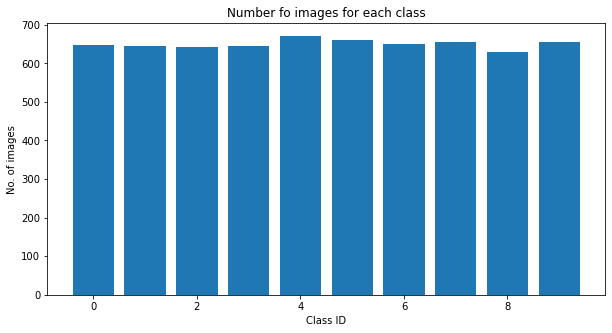

In [6]:
plt.figure(figsize=(10,5))

plt.bar(range(10), noOfSample)
plt.title("Number fo images for each class")
plt.xlabel("Class ID")
plt.ylabel("No. of images")
plt.show()

In [7]:
def preProcessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img/255
    return img

In [8]:
X_train = np.array(list(map(preProcessing, X_train)))
X_test = np.array(list(map(preProcessing, X_test)))
X_val = np.array(list(map(preProcessing, X_val)))
print("Training set: ",X_train.shape)
print("Testing set: ",X_test.shape)
print("Val set: ",X_val.shape)

Training set:  (6502, 32, 32)
Testing set:  (2032, 32, 32)
Val set:  (1626, 32, 32)


In [9]:
X_train = X_train.reshape( X_train.shape[0],  X_train.shape[1],  X_train.shape[2], 1)
X_test = X_test.reshape( X_test.shape[0],  X_test.shape[1],  X_test.shape[2], 1)
X_val = X_val.reshape( X_val.shape[0],  X_val.shape[1],  X_val.shape[2], 1)
print("Training set: ",X_train.shape)
print("Testing set: ",X_test.shape)
print("Val set: ",X_val.shape)

Training set:  (6502, 32, 32, 1)
Testing set:  (2032, 32, 32, 1)
Val set:  (1626, 32, 32, 1)


In [10]:
dataGen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.2,
                            rotation_range=10)
dataGen.fit(X_train)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_val = to_categorical(y_val, 10)

In [26]:
def model():
    filters = 60
    size_f1 = (5,5)
    size_f2 = (3,3)
    size_pool = (2,2)
    nodes = 500
    model = keras.Sequential()
    model.add((Conv2D(filters, size_f1, input_shape = (32,32,1), activation = "relu")))
    model.add((Conv2D(filters, size_f1, activation = "relu")))
    model.add(MaxPooling2D(pool_size = size_pool))
    model.add((Conv2D(filters//2, size_f2, activation = "relu")))
    model.add((Conv2D(filters//2, size_f2, activation = "relu")))
    model.add(MaxPooling2D(pool_size = size_pool))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(nodes, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))
    model.compile(Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [27]:
model = model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 30)         

In [30]:
for i in range(3):
    history = model.fit(dataGen.flow(X_train, y_train, batch_size=50),
                       steps_per_epoch=len(X_train)//50,
                       epochs=10,
                       validation_data=(X_val, y_val),
                       shuffle=1)

Epoch 1/10
130/130 [==============================] - 55s 422ms/step - loss: 0.3807 - accuracy: 0.8830
Epoch 2/10
130/130 [==============================] - 58s 444ms/step - loss: 0.2572 - accuracy: 0.9160
Epoch 3/10
130/130 [==============================] - 52s 396ms/step - loss: 0.2199 - accuracy: 0.9320
Epoch 4/10
130/130 [==============================] - 52s 398ms/step - loss: 0.1802 - accuracy: 0.9431
Epoch 5/10
130/130 [==============================] - 51s 393ms/step - loss: 0.1589 - accuracy: 0.9481
Epoch 6/10
130/130 [==============================] - 50s 382ms/step - loss: 0.1476 - accuracy: 0.9561
Epoch 7/10
130/130 [==============================] - 50s 385ms/step - loss: 0.1349 - accuracy: 0.9572
Epoch 8/10
130/130 [==============================] - 55s 422ms/step - loss: 0.1353 - accuracy: 0.9580
Epoch 9/10
130/130 [==============================] - 81s 623ms/step - loss: 0.1141 - accuracy: 0.9628
Epoch 10/10
130/130 [==============================] - 79s 602ms/step - l

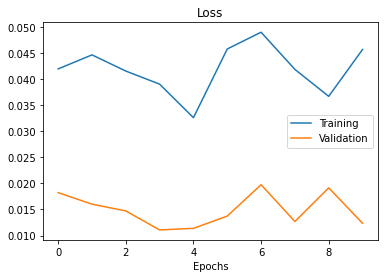

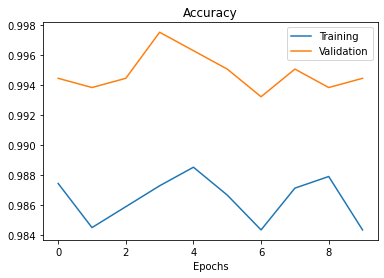

In [31]:
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title("Loss")
plt.xlabel("Epochs")

plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.show()

In [32]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test Score: ", score[0])
print("Test Accuracy: ", score[1])

Test Score:  0.01008786354213953
Test Accuracy:  0.998031497001648


In [35]:
model.save('C:/Users/piyus/Desktop/mywork/Image Sudoku/Sudoku/digit_predictor.h5')